# EXP 16 다음에 볼 영화 예측하기 


* 이번 시간에는 전자상거래에서 많이 쓰이는 Session based Recommendation 시스템 에 대해 배워보았고, E-Commerce 데이터셋을 가져와 모델을 구축하고, 학습하여 MRR과 Recall@k 지표를 이용해 모델의 성능을 평가 해 봤습니다. 


* 이번 프로젝트에선 `Movielens 1M Dataset` 을 기반으로, `Session based Recommendation` 시스템을 제작해 보겠습니다.  



----



# 루브릭 평가 기준


| 평가문항 | 상세기준 |
| :---: | :---: |
| 1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다. | 데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다. |
| 2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다. | 적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다. |
| 3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다. | 3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다. |



----




# 목차 

## 1. 데이터셋, 라이브러리 불러오기


## 2. 데이터의 전처리


## 3. 데이터셋 분리 & 미니 배치의 구성


## 4. 모델 구성


## 5. 모델 학습


## 6. 모델 테스트 


## 회고!


## 🖇️참고 페이지 




-----




# 1. 데이터셋, 라이브러리 불러오기


* 이번 프로젝트에 필요한 라이브러리와 데이터셋을 불러옵니다. 
* 데이터셋은 클라우드에 있기 때문에 경로로 불러와 주겠습니다. 

## &nbsp;&nbsp; 1-1 라이브러리 불러오기 

In [1]:
import datetime as dt
from pathlib import Path
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import time, datetime

from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [2]:
# 주요 라이브러리 버전을 확인 합니다. 
print(pd.__version__)
print(tf.__version__)

1.3.3
2.6.0


## &nbsp;&nbsp; 1-2 디렉토리 생성하기 


* 디렉토리는 LMS 진행중 해 주었으므로 추가로 해 주진 않습니다. 

In [3]:
# 1) 데이터 확인
# $ ls -l ~/data

# 2) 프로젝트 폴더 생성
# $ mkdir -p ~/aiffel/yoochoose

# 3) 프로젝트 폴더로 데이터 폴더 링크 연결
# $ ln -s ~/data/* ~/aiffel/yoochoose/data

## &nbsp;&nbsp; 1-3 데이터 불러오기 및 확인하기 


* 필요한 데이터셋을 불러옵니다. 
* 추천 시스템을 구축할 때 가장 먼저 유저 수(세션수) 와 아이템 수를 먼저 확인 해 봐야 합니다. 
* 각 세션이 대략 몇 개의 클릭 데이터를 갖는 지도 살펴봅시다. 

### 이전 실습 내역과 다른 부분이 있습니다! 주의하면서 노드를 진행 해 주세요:D 


1. **SessionID 대신 UserID 항목이 들어갔다.**  
    명확한 1회 세션의 Session ID를 포함하고 있지 않기 때문에, 그 역할을 UserID가 합니다. 
    
    
2. **Rating 정보가 포함되어 있습니다.**  
    별점 정보! 직전에 봤던 영화의 선호도에 따라 비슷한 영화를 더 고르게 하는것과 상관이 있을 수도 있다. 
    Rating이 낮은 데이터는 어떻게 처리할까요? (이거 이전 노드에 있었지 rating 3 미만은 지우는거)


3. **Time 항목에는 UCT time이 포함되어 1970년 1월 1일부터 경과된 초 단위 시간(timestamp)이 기재되어 있습니다.**

###  &nbsp;&nbsp;&nbsp;&nbsp; 1-3-1 데이터 불러오기 

In [4]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'timestamp']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'timestamp'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,timestamp
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


###  &nbsp;&nbsp;&nbsp;&nbsp; 1-3-2 유저 수(세션수) 와 아이템 수 확인하기 

In [5]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

* 세션(User ID)의 개수 : 6040개 
    * 같은 유저가 여러 개의 세션을 만들었기 때문에 세션의 개수가 아이템의 개수에 비해 많은 것. 


* 아이템 개수 : 3706개 

In [6]:
print(data.loc[data['UserId'] == 1])

    UserId  ItemId  Rating  timestamp
31       1    3186       4  978300019
22       1    1270       5  978300055
27       1    1721       4  978300055
37       1    1022       5  978300055
24       1    2340       3  978300103
36       1    1836       5  978300172
3        1    3408       4  978300275
7        1    2804       5  978300719
47       1    1207       4  978300719
0        1    1193       5  978300760
21       1     720       3  978300760
44       1     260       4  978300760
9        1     919       4  978301368
51       1     608       4  978301398
43       1    2692       4  978301570
41       1    1961       5  978301590
48       1    2028       5  978301619
18       1    3105       5  978301713
11       1     938       4  978301752
14       1    1035       5  978301753
42       1    1962       4  978301753
17       1    2018       4  978301777
39       1     150       5  978301777
45       1    1028       5  978301777
26       1    1097       4  978301953
2        1  

* 실제로 user id가 1이란 사람은 53편의 영화를 보고 별점을 매겼다고 확인할 수 있습니다.




----




# 2. 데이터의 전처리

## &nbsp;&nbsp; 2-1 timestamp 변환하기 


* Session Time 에서 활용해 주기 위해 timestamp 형식으로 되어있는 날짜 및 시간 값을 년/월/일/시간 으로 변환해 줍니다. 


### &nbsp;&nbsp;&nbsp;&nbsp;타임스탬프 시간
&nbsp;&nbsp;&nbsp;&nbsp;-> 시간을 밀리세컨드(1/1000초)로 나타낸 값 

In [7]:
data['timestamp']

31         978300019
22         978300055
27         978300055
37         978300055
24         978300103
             ...    
1000019    997454429
999988     997454464
1000172    997454464
1000167    997454486
1000042    998315055
Name: timestamp, Length: 1000209, dtype: int64

In [8]:
#pandas의 to_datetime 을 이용해 timestamp를 년/월/일 시간이 표기된 데이터로 바꿔줍니다. 
data['Time'] = pd.to_datetime(data['timestamp'], unit='s')

In [9]:
data.tail(5)

,UserId,ItemId,Rating,timestamp,Time
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000172,6040,1784,3,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26
1000042,6040,1221,4,998315055,2001-08-20 13:44:15


##  &nbsp;&nbsp; 2-2 Session Length 

- 여기서의 세션 길이란건 user 1명이 별점을 매긴 영화들의 개수 라고 생각할 수 있겠다. 
    - 설명하기 쉽게 영화에 평점을 매김 = 영화를 시청함 으로 이해하고 넘어가겠습니다. 
    
    
- 각 세션이 대략 몇 개의 클릭 데이터를 갖는 지도 살펴봅니다.


- `session_length`
    - 같은 `SessionId`를 공유하는 데이터 row의 개수를 의미함.
    - 해당 세션의 사용자가 그 세션동안 몇번의 액션을 취했는지( 몇 개의 상품정보를 클릭했는지)의 의미가 됨.
    
    
- `User ID`
    - 브라우저에서 웹서버로 접속할 때 항상 포함하게 되는 유저 구분자
    - 영화 스트리밍 사이트이기 때문에, 반드시 로그인 해야 시청 및 별점을 남길 수 있을 것이므로   
      사용자들의 행동을 모아서 분류 해 낼 수 있습니다. 

In [10]:
# user들이 본 영화 수량.
# ex) userid 1 이란 사람이 본 영화 수량은 53개 입니다. 
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [11]:
# 세션 길이의 중간값과 평균 
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

* user들은 평균적으로 약 165편의 영화를 봤습니다. 

In [12]:
# 세션 길이의 최솟값과 최댓값 
session_length.min(), session_length.max()

(20, 2314)

* 영화를 가장 많이 본 유저는 2314편의 영화를 봤고, 적게 본 유저는 20편의 영화를 재생했습니다. 

In [13]:
# 세션 길이의 변위 수?

session_length.quantile(0.999)

1343.181000000005

* 변위 수
 
 -> 오름차순 or 내림차순 정렬 되어 있는 전체 자료를 특정 개수로 나눌때, **그 기준이 되는 수**를 변위수 라 합니다.

 
    * 2분위수 = median
    * 4분위수 = 자료 전체를 4등분 하는 수들이란 의미 = quartiles


* 99.9% 인 세션의 길이는 1343.1 
* 최대 길이인 2314의 세션을 확인해 봅시다. 

In [14]:
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,timestamp,Time
696969,4169,1268,5,965333392,2000-08-03 20:09:52
697168,4169,2617,4,965333392,2000-08-03 20:09:52
697185,4169,2628,4,965333392,2000-08-03 20:09:52
697219,4169,2653,4,965333392,2000-08-03 20:09:52
697275,4169,423,3,965333392,2000-08-03 20:09:52
...,...,...,...,...,...
697882,4169,3754,2,1024174347,2002-06-15 20:52:27
695702,4169,1413,3,1024175031,2002-06-15 21:03:51
697358,4169,494,4,1024175760,2002-06-15 21:16:00
695945,4169,1804,2,1024175783,2002-06-15 21:16:23


* 영화 평가를 매우 짧은시간에 많이 한 것을 알 수 있는데, 서비스하는 영화를 이전에 본 적이 있어, 영화에 대한 평점을 바로바로 매겼기 때문에 저런 결과가 나온 것이 아닐까 추측해본다. 


* 세선 길이 기준 하위 99.9% 까지의 분포 누적합을 시각화 해 보겠습니다.

In [15]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

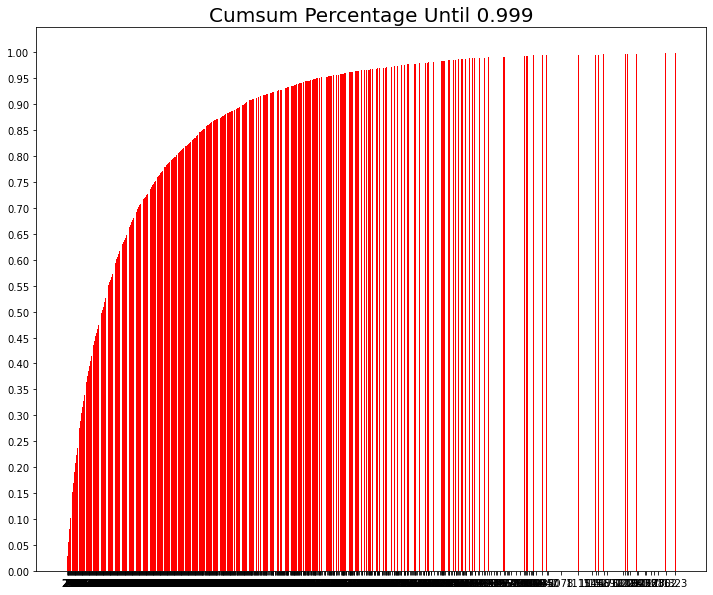

In [16]:
plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

(lms 노드 처럼 큰 뭉터기로 해서 나눠서 보여주면 좋을텐데.. ) 이럼 확인 하기도 어렵자너.. 

- User * Item Matrix의 빈칸이 너무 많아서(data sparsity) 모델이 제대로 학습되지 않을 가능성이 있다. lms의 세션정보는 유저를 ID 기반으로 정리할 수 없기 때문에 세션 하나를 유저 하나로 본다면 기존의 유저-상품정보 Matrix보다 훨씬 sparse한 형태가 된다.
- 하지만 우리데이터는 id 기반으로 정리 할 수 있기 때문에  Matrix Factorization 모델을 사용 해줄 수 있지 않을까? 


##  &nbsp;&nbsp; 2-3 Session Time


* 유저들의 소비 패턴은 금방금방 변하기 때문에, 추천 시스템을 구축할 때에는 최근 소비 트렌드를 학습하는 것이 중요합니다. 데이터가 발생한 시간에 대해 알아봅니다. 


* 추천 시스템에서 다루는 시간 관련 데이터는 데이터 생성 날짜 말고도 접속하는 시간대, 접속 해 있는 시간, 접속 요일, 계절, 마지막 접속 시간, 장바구니에 넣고 지난 시간 등등 의 요소가 있습니다. 


- 우리가 다루려는 데이터의 시간 관련 정보를 확인 해봅시다.

In [17]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


* 약 3년치의 데이터가 있는 것을 확인 할 수 있었습니다. 

In [18]:
# latest 의 data type 
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

* 날짜끼리의 차이를 구하고 싶을땐 datatime 라이브러리의 timedelta 객체를 사용합니다.

In [19]:
data

,UserId,ItemId,Rating,timestamp,Time
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
27,1,1721,4,978300055,2000-12-31 22:00:55
37,1,1022,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000172,6040,1784,3,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26


In [20]:
# 1달치 데이터만 사용하기 위해서 썼던 처리 방법. 
# 3년치 데이터를 전부 사용해 보기 위해 주석처리 해 주었습니다. 
# month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구한다.  
# data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
# data

##  &nbsp;&nbsp; 2-4  Data Cleansing


* 예제에선 클릭 수가 적은것을 없애줬다면, 우린 별점이 3점 이하 인 항목을 날려주도록 해 보겠습니다. 
- 별 3개 이상의 평가가 들어간 작품을 다음 영화로 추천 해 준다면, 사용자의 취향과 좀 더 잘 맞는 영화를 추천 해 줄 수 있을것 같다고 생각합니다. 
* 우선, 'rating' 마다 몇개의 데이터가 들어가 있는지 확인 해 보고, 
* 'rating'이 3 미만인 평가가 들어간 항목은 제외하겠습니다. 

* `cleanse_short_session` : 이번 예제에선 유저가 최소 1개 이상 클릭 했는지를 알아보고, 1개 이상이 아니라면 제거 해 주는 역할을 했던 함수. 


* `cleanse_unpopular_Rating` : (노드에선 `cleanse_unpopular_item` 으로, 적게 클릭된 아이템을 삭제해 가는 함수였다.) 여기선 rating의 별점이 3점 이하인 리뷰를 삭제할 때 사용하였다.  

* 였지만, 우린 유저의 수를 날리는 것이 아니라, 별점이 낮은 평가를 날리는 것이 목표이기 때문에 예제에 있던 함수는 사용하지 않았습니다. 

In [21]:
# 'Rating' 을 그룹화 해서 각 rating 별로 몇개의 평가가 있는지 알아봅니다. 
movie_popular = data.groupby('Rating').size()
movie_popular

Rating
1     56174
2    107557
3    261197
4    348971
5    226310
dtype: int64

In [22]:
# data의 rating이 3보다 크거나 같은것만 남겨줍니다. 
data = data[data['Rating'] >= 3]
data

,UserId,ItemId,Rating,timestamp,Time
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
27,1,1721,4,978300055,2000-12-31 22:00:55
37,1,1022,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000172,6040,1784,3,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26


In [23]:
# 잘 처리 됬나 확인 해보면? 
movie_popular = data.groupby('Rating').size()
movie_popular

Rating
3    261197
4    348971
5    226310
dtype: int64

In [24]:
data[data['Rating'] == 1]

,UserId,ItemId,Rating,timestamp,Time


In [25]:
data.loc[data['Rating'] == 5]

,UserId,ItemId,Rating,timestamp,Time
22,1,1270,5,978300055,2000-12-31 22:00:55
37,1,1022,5,978300055,2000-12-31 22:00:55
36,1,1836,5,978300172,2000-12-31 22:02:52
7,1,2804,5,978300719,2000-12-31 22:11:59
0,1,1193,5,978300760,2000-12-31 22:12:40
...,...,...,...,...,...
999975,6040,3182,5,984195682,2001-03-10 03:41:22
1000035,6040,1212,5,997453796,2001-08-10 14:29:56
1000034,6040,1211,5,997454080,2001-08-10 14:34:40
999905,6040,953,5,997454160,2001-08-10 14:36:00


* 이것으로 전처리가 모두 끝났다. 




-----




# 3. 데이터셋 분리 & 미니 배치의 구성


* 위에서 전처리 한 데이터를 가져와, train, validation, test 로 나눠줍니다. 
* 가장 마지막 1일 기간 동안을 Test로, 2일 전부터 1일 전 까지를 valid set으로 나누겠습니다.

##  &nbsp;&nbsp; 3-1 데이터셋 분리 


* train, test, validation 으로 데이터셋을 분리합니다. 
* 데이터를 나누는 기준은 총 3년치의 데이터 중, train은 마지막 날짜로부터 120일 이전까지의 데이터, val은 그 120일 이전 부터 120일, train 으론 나머지 데이터를 사용하고 싶었지만,   
* 자꾸 나눴을 때의 일자가 원하는데로 나오지 않았습니다. 어떤 점이 문제가 됬는지를 찾지 못해 우선은 기준 일수를 나타내는 것 같은 `n_days`에 120을 넣고 진행하겠습니다. 

In [26]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [27]:
# Train test data 분리
tr, test = split_by_date(data, n_days=120)

# 나눈 Train 에서 Train, validation 으로 나눠줍니다.
tr, val = split_by_date(tr, n_days=120)

In [28]:
session_last_time = data.groupby('UserId')['Time'].max()
session_last_time

UserId
1      2001-01-06 23:39:11
2      2000-12-31 22:02:54
3      2000-12-31 21:35:04
4      2000-12-31 20:24:42
5      2000-12-31 07:09:36
               ...        
6036   2000-04-26 13:18:11
6037   2000-04-27 02:17:20
6038   2000-04-26 02:46:44
6039   2000-04-26 14:07:09
6040   2001-08-20 13:44:15
Name: Time, Length: 6039, dtype: datetime64[ns]

In [29]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [30]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')


* train Set Stats Info
	 Events: 710256
	 Sessions: 5661
	 Items: 3600
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-07-02 15:40:10

* valid Set Stats Info
	 Events: 31758
	 Sessions: 106
	 Items: 2835
	 First Time : 2000-04-30 06:37:43
	 Last Time : 2002-10-31 16:33:08

* test Set Stats Info
	 Events: 94429
	 Sessions: 272
	 Items: 3250
	 First Time : 2000-04-27 16:38:08
	 Last Time : 2003-02-28 17:49:50



In [31]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

* 데이터 준비가 완료되었습니다. 데이터를 저장한 다음, data pipeline을 구축하는 단계로 넘어갑니다. 

In [32]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

##  &nbsp;&nbsp; 3-2 Data Pipeline


* Session-Parallel Mini-Batch 를 구현 해 봅시다. 

* 우선, 데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만듭니다.

In [33]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

- train데이터로 `SessionDataset` 객체를 만들고 인스턴스 변수들을 살펴보겠습니다.
- `click_offsets`
    - 각 세션이 시작된 인덱스를 담고 있습니다.
- `session_idx`
    - 각 세션을 인덱싱한 `np.array` 입니다.

In [34]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)


,UserId,ItemId,Rating,timestamp,Time,item_idx
31,1,3186,4,978300019,2000-12-31 22:00:19,0
22,1,1270,5,978300055,2000-12-31 22:00:55,1
27,1,1721,4,978300055,2000-12-31 22:00:55,2
37,1,1022,5,978300055,2000-12-31 22:00:55,3
24,1,2340,3,978300103,2000-12-31 22:01:43,4
36,1,1836,5,978300172,2000-12-31 22:02:52,5
3,1,3408,4,978300275,2000-12-31 22:04:35,6
7,1,2804,5,978300719,2000-12-31 22:11:59,7
47,1,1207,4,978300719,2000-12-31 22:11:59,8
0,1,1193,5,978300760,2000-12-31 22:12:40,9


In [35]:
tr_dataset.click_offsets

array([     0,     53,    169, ..., 709861, 709980, 710256], dtype=int32)

In [36]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 5658, 5659, 5660])

- `SessionDataset`객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만듭니다.
- `__iter__` 메서드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 `yield` 합니다.  
  mask는 후에 RNN Cell State를 초기화하는데 사용할 것입니다.

In [37]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [38]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,timestamp,Time,item_idx
31,1,3186,4,978300019,2000-12-31 22:00:19,0
22,1,1270,5,978300055,2000-12-31 22:00:55,1
27,1,1721,4,978300055,2000-12-31 22:00:55,2
37,1,1022,5,978300055,2000-12-31 22:00:55,3
24,1,2340,3,978300103,2000-12-31 22:01:43,4
36,1,1836,5,978300172,2000-12-31 22:02:52,5
3,1,3408,4,978300275,2000-12-31 22:04:35,6
7,1,2804,5,978300719,2000-12-31 22:11:59,7
47,1,1207,4,978300719,2000-12-31 22:11:59,8
0,1,1193,5,978300760,2000-12-31 22:12:40,9


In [39]:
iter_ex = iter(tr_data_loader)

In [40]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 64 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []





-----




# 4. 모델 구성


* Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋습니다.
- 이번 자료에선 `MRR`과 `Recall@k`를 사용하겠습니다.
    - `MRR`은 정답 아이템이 나온 순번의 역수 값

In [41]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [42]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

- 모델에 사용할 hyper-parameter를 class형식으로 관리하겠습니다.

In [43]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.0001, epochs=3, k=20)


In [44]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 1, 3600)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      547800    
_________________________________________________________________
dropout (Dropout)            (64, 50)                  0         
_________________________________________________________________
dense (Dense)                (64, 3600)                183600    
Total params: 731,400
Trainable params: 731,400
Non-trainable params: 0
_________________________________________________________________





-----




# 5. 모델 학습

In [45]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [46]:
train_model(model, args)


Evaluation:  61%|██████    | 301/494 [01:49<01:10,  2.75it/s]


	 - Recall@20 epoch 1: 0.057101
	 - MRR@20    epoch 1: 0.010972



Evaluation:  61%|██████    | 301/494 [01:48<01:09,  2.78it/s]


	 - Recall@20 epoch 2: 0.072934
	 - MRR@20    epoch 2: 0.014789



Evaluation:  61%|██████    | 301/494 [01:47<01:08,  2.80it/s]

	 - Recall@20 epoch 3: 0.082070
	 - MRR@20    epoch 3: 0.016491






-----




# 6. 모델 테스트 


- 지금까지 작성한 모델이 테스트셋에 대해서 어느 정도 성능을 내는지 검증해 봅시다.


In [47]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  82%|████████▏ | 1206/1471 [07:14<01:35,  2.77it/s]

	 - Recall@20: 0.063277
	 - MRR@20: 0.012902






-----




#### 7. 모델 개선! 


* 하이퍼 파라미터를 조금 씩 조정해, 모델을 개선 해 봅니다. 
* batch size는 64이상을 주게 되면 오류가 발생하기 때문에 그 외의 값만 수정해서 개선 해 보겠습니다.
- 기본값 ` batch_size=64, hsz=50, drop_rate=0.1, lr=0.0001, epochs=3, k=20` 

##  &nbsp;&nbsp; 7-1 `lr=0.01`


* 학습률을 0.0001 에서 0.01 로 변경. 

In [53]:
args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.01, epochs=3, k=20)
train_model(model, args)

Evaluation:  61%|██████    | 301/494 [01:38<01:02,  3.07it/s]


	 - Recall@20 epoch 1: 0.261109
	 - MRR@20    epoch 1: 0.066758



Evaluation:  61%|██████    | 301/494 [01:38<01:03,  3.05it/s]


	 - Recall@20 epoch 2: 0.266144
	 - MRR@20    epoch 2: 0.068495



Evaluation:  61%|██████    | 301/494 [01:37<01:02,  3.08it/s]

	 - Recall@20 epoch 3: 0.271076
	 - MRR@20    epoch 3: 0.069754



In [54]:
# 모델 검증!
test_model(model, args, test)

Evaluation:  82%|████████▏ | 1206/1471 [06:42<01:28,  3.00it/s]

	 - Recall@20: 0.223816
	 - MRR@20: 0.055935



##  &nbsp;&nbsp; 7-2 `lr=0.01`, `epochs=5`



In [55]:
args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.01, epochs=5, k=20)
train_model(model, args)

Evaluation:  61%|██████    | 301/494 [01:38<01:03,  3.05it/s]


	 - Recall@20 epoch 1: 0.274865
	 - MRR@20    epoch 1: 0.071132



Evaluation:  61%|██████    | 301/494 [01:38<01:02,  3.06it/s]


	 - Recall@20 epoch 2: 0.278187
	 - MRR@20    epoch 2: 0.072791



Evaluation:  61%|██████    | 301/494 [01:37<01:02,  3.07it/s]


	 - Recall@20 epoch 3: 0.281665
	 - MRR@20    epoch 3: 0.073731



Evaluation:  61%|██████    | 301/494 [01:38<01:02,  3.07it/s]


	 - Recall@20 epoch 4: 0.283586
	 - MRR@20    epoch 4: 0.074501



Evaluation:  61%|██████    | 301/494 [01:37<01:02,  3.10it/s]

	 - Recall@20 epoch 5: 0.285974
	 - MRR@20    epoch 5: 0.075425



In [56]:
# 모델 검증!
test_model(model, args, test)

Evaluation:  82%|████████▏ | 1206/1471 [06:39<01:27,  3.02it/s]

	 - Recall@20: 0.238754
	 - MRR@20: 0.061319



##  &nbsp;&nbsp; 7-3 `lr=0.001`, `epochs=5`, `drop_rate=0.4`


In [50]:
args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.4, lr=0.001, epochs=5, k=20)
train_model(model, args)

Evaluation:  61%|██████    | 301/494 [01:40<01:04,  3.00it/s]


	 - Recall@20 epoch 1: 0.227159
	 - MRR@20    epoch 1: 0.055772



Evaluation:  61%|██████    | 301/494 [01:39<01:03,  3.02it/s]


	 - Recall@20 epoch 2: 0.235050
	 - MRR@20    epoch 2: 0.058583



Evaluation:  61%|██████    | 301/494 [01:39<01:03,  3.03it/s]


	 - Recall@20 epoch 3: 0.241591
	 - MRR@20    epoch 3: 0.060547



Evaluation:  61%|██████    | 301/494 [01:39<01:03,  3.04it/s]


	 - Recall@20 epoch 4: 0.248339
	 - MRR@20    epoch 4: 0.063237



Evaluation:  61%|██████    | 301/494 [01:39<01:03,  3.04it/s]

	 - Recall@20 epoch 5: 0.254620
	 - MRR@20    epoch 5: 0.065074



In [52]:
# 모델 검증!
test_model(model, args, test)

Evaluation:  82%|████████▏ | 1206/1471 [06:48<01:29,  2.95it/s]

	 - Recall@20: 0.211831
	 - MRR@20: 0.051877



# 회고!

* 모델 검증에 대한 해석이 부족해서 제대로 학습이 되었는지도 분석 해 볼 수 없었다. 시간을 조금 더 투자해서 출력 값에 대한 해석을 해봤더라면 개선 사항을 시도 했을 때 방향을 잡기 쉬웠을 것이다. 무작정 값을 찾아가는 과정도 좋긴 하지만, 좀 더 배운걸 응용해서 값을 찾아나간다면 더 의미있는 프로젝트가 될 것이다. 



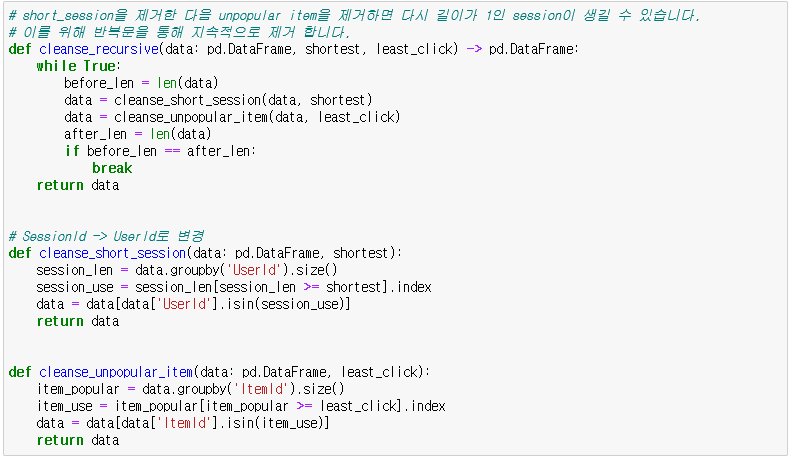  
* 과감한 시도가 필요하다. 이 위에 있는 이미지↑를 하나하나 뜯어보고 이해 해 보면, 프로젝트에선 필요 없는 코드고, 다르게 처리 해 줄 수 있는 방법이 있었는데 솔직히 잘 못될  까봐 무서워서 뜯어고치지 못 했다. 결국 우수노드 보고 아 없어도 되는구나 라는 확신을 가졌는데, 코드 공부 해 가면서 하면서 없어도 되는부분은 과감하게 빼는 시도를 해 봐도 좋을것 같다. 일단 해 보고 안되면 다시 돌아오면 되니깐! 너무 겁 먹지 말기.. 

---

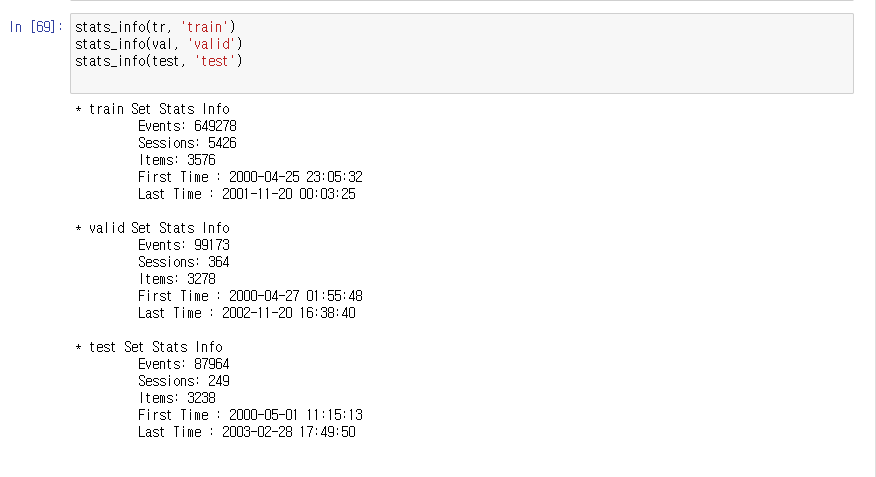  
* 또한 해결되지 못 하구 그대로 넘어갔던 부분이 한가지 더 있는데, 데이터셋을 train, test, val 로 나눠주는 과정이다. First time과 last time의 날짜 간격이 일정하지 않다. test set의 경우, 제일 늦은 날짜가 적어도 2002년어야 하지만, 출력된값은 2000년이다. `sort` 를 이용해 정렬해 주면 될 줄 알구 시도 했지만 출력 값에는 변경이 없었다.  시도하다하다 안되서 일단 넘어갔는데, test data가 최신이 아닐 경우, (데이터셋 기준)최신 트렌드에 맞는 영화 추천을 해 줄 수 없을것이다. 좀 더 공부하면서 수정해봐야지.. 




-----




# 🖇️참고 페이지 




### 데이터 처리 관련 

* [특정 값과 일치하는 행 인덱스 가져오기 ](https://www.delftstack.com/ko/howto/python-pandas/pandas-get-index-of-row/)


* [timestamp_to_datetime](https://blog.doosikbae.com/89)

### 변위수
* [변위수가 뭔지 몰라 찾아봤더래요](https://hsm-edu.tistory.com/533)

### cleanse_recursive 

* [강양인 권승민님 프로젝트](https://github.com/Kwon-Seung-Min/AIFFEL-Exp-KSM/blob/master/Exp12_final_ksm.ipynb)